## This notebook explains the following DANDIset:
https://dandiarchive.org/dandiset/000168/

## Please read the paper for additional information:
https://doi.org/10.1101/2021.11.08.467793 

## This notebook is available here:
https://raw.githubusercontent.com/rozmar/jGCaMP8_mouse_cell_attached_pipeline/master/NWB_tutorial.ipynb

# Dataset description

This dataset contains simultaneous 2-photon calcium imaging movies and loose-seal cell attached recordings of upper layer 2 pyramidal cells and interneurons of the primary visual cortex of wild type mouse, in vivo, during drifting gratings stimulus in the contralateral eye.
jGCaMP8f, jGCaMP8m, jGCaMP8s, jGCaMP7f and XCaMPgf were expressed via AAV injections using synapsin-2 promoter.

Multiple neruons were recorded in each mouse, and multiple ~3-minutes-long recordings (movies/sweeps) were performed for each cell. One .nwb file contains all the data for a given cell. 

The dataset contains:
- raw 2-photon movies
- raw cell attached loose-seal electrophysiology traces of a single neuron in the field of view
- somatic cellular and neuropil ROIs that were segmented with Suite2p
- the fluorescent transients for all ROIs
- details of the drifting gratings stimuli presented to the contralateral eye



### Load necessary libraries
These libraries are necessary for this script, please install if not available

In [1]:
import pynwb
from nwbwidgets import nwb2widget
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
import numpy as np
import scipy.ndimage as ndimage
import os
%matplotlib inline
from PIL import Image
try:
    from ScanImageTiffReader import ScanImageTiffReader
except:
    pass
def gaussFilter(sig,sRate,sigma = .01):
    si = 1/sRate
    sig_f = ndimage.gaussian_filter(sig,sigma/si)
    return sig_f

def read_tiff(path, n_images=1000000):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)

    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            img.getpixel((1, 1))
            images.append(np.array(img))
        except EOFError:
            # Not enough frames in img
            break
    return np.array(images)

### In case you use DANDI-hub (http://hub.dandiarchive.org), please run the cell below
For a quick walktrough how to use dandihub, please see the following video: https://youtu.be/8OMLmUnc6Cs?t=3060

In [2]:
from pynwb import NWBHDF5IO
import requests

dandihub = True 
dandiset_id = "000168"

def _search_assets(url, filepath):
    response = requests.request("GET", url, headers={"Accept": "application/json"}).json() 
    
    for asset in response["results"]:
        if filepath == asset["path"]:
            return asset["asset_id"]
    
    if response.get("next", None):
        return _search_assets(response["next"], filepath)
    
    raise ValueError(f'path {filepath} not found in dandiset {dandiset_id}.')


def get_asset_id(dandiset_id, filepath):
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/"
    return _search_assets(url, filepath)

def get_s3_url(dandiset_id, filepath):
    """Get the s3 location for any NWB file on DANDI"""

    asset_id = get_asset_id(dandiset_id, filepath)
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/draft/assets/{asset_id}/download/"
    
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

### In case you use local files, please complete and run the cell below
Note that this script assumes that the files in the base directory has the same directory structure as in the dandiset (e.g. you have downloaded the whole dataset).

In [3]:
dandihub = False
base_dir_ = '/home/rozmar/Data/Calcium_imaging/GCaMP8_NWB/DANDI/000168/' # this points to the root directory of the dandiset

### Select Subject ID and cell number
The name of the sensor expressed by the recorded cell is also in the file name, please change that accordingly, use supplementary table 5 from the paper or look up the name of the .nwb file.

In [4]:
sensor = 'jGCaMP8s' #name of the sensor in that experiment (jGCaMP8s/jGCaMP8m/jGCaMP8f/jGCaMP7f/XCaMPgf)
subject_id = 472182 #ID of the mouse
cell_number = 1     #ID of the cell in this subject

gauss_filter_sigma = 10 #ms - only to make the final plot smoother

if dandihub:
    filepath = os.path.join(sensor,'{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2)))
    s3_path = get_s3_url(dandiset_id, filepath)
    io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')
else:
    base_dir = os.path.join(base_dir_,sensor)
    nwbfile = os.path.join(base_dir,'{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2)))
    io = pynwb.NWBHDF5IO(nwbfile, 'r')
    
nwbfile = io.read()

print('Available movies are: {}'.format(list(nwbfile.imaging_planes.keys())))

Available movies are: ['Movie_0', 'Movie_1', 'Movie_2', 'Movie_3', 'Movie_4', 'Movie_5', 'Movie_6']


The .nwb file contains rich metadata about the devices, mouse, virus injection..

In [5]:
nwb2widget(nwbfile)
nwbfile

[datetime.datetime(2021, 11, 16, 22, 28, 27, 212009, tzinfo=tzoffset(None, -18000))]


root pynwb.file.NWBFile at 0x140348435364944
Fields:
  acquisition: {
    Registered movie 0 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 3 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 4 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 5 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 6 <class 'pynwb.ophys.TwoPhotonSeries'>,
    loose seal recording for movie 0 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 1 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 2 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 3 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 4 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 5 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose 

# Select a movie from the imaging planes.
Available movie numbers are in the output of the cells above.

In [6]:
movie_number = 1


if 'Movie_{}'.format(movie_number) not in nwbfile.imaging_planes.keys():
    print('!!! Not a valid movie number, please choose from: {}'.format(list(nwbfile.imaging_planes.keys())))

# Imaging plane
The imaging plane contains metadata about the experiment, now we will use only the pixel size in this example

In [7]:
imaging_plane = nwbfile.imaging_planes['Movie_{}'.format(movie_number)]
print(imaging_plane)
movie_pixel_size = imaging_plane.grid_spacing[0]

Movie_1 pynwb.ophys.ImagingPlane at 0x140348435212432
Fields:
  conversion: 1.0
  description: Simultaneous loose-seal recording and calcium imaging in V1
  device: MMIMS: custom-built two-photon microscope with a resonant scanner pynwb.device.Device at 0x140348440573392
  excitation_lambda: 940.0
  imaging_rate: 121.97367008456484
  indicator: jGCaMP8s
  location: V1
  optical_channel: (
    green <class 'pynwb.ophys.OpticalChannel'>
  )
  reference_frame: surface of the cortex
  unit: meters



# Ophys
The following lines show how to extract the mean image of the selected movie, the ROI and neuropil traces and the ROI and neuropil pixels. To make the data easier to interpret, we do neuropil correction, dF/F is calculated, and a gaussian filter is applied to the extracted traces. The ROI that is recorded with ephys is also labelled, it is also always the first ROI.

In [8]:
ophys = nwbfile.processing['ophys of movie {}'.format(movie_number)]

meanimages = ophys['mean images of movie {}'.format(movie_number)]
mean_image_GCaMP = meanimages.images['{} at 940nm'.format(sensor)].data[:]

roi_traces = ophys['Fluorescence']['RoiResponseSeries'].data[:]
neuropil_traces = ophys['Fluorescence']['NeuropilResponseSeries'].data[:]

recorded_with_ephys = ophys['ImageSegmentation']['MovieSegmentation']['recorded_with_ephys'].data[:]
putative_cell_type = ophys['ImageSegmentation']['MovieSegmentation']['cell_type'].data[:]
roi_time = ophys['Fluorescence']['RoiResponseSeries'].timestamps[:]
roi_dff_list = []
for roi_i,(roi_trace,neuropil_trace,recorded_cell,cell_type) in enumerate(zip(roi_traces,neuropil_traces,recorded_with_ephys,putative_cell_type)):
    f_corrected = roi_trace-0.8*neuropil_trace
    f0 = np.percentile(f_corrected,20)
    dff = (f_corrected-f0)/f0
    dff = gaussFilter(dff,imaging_plane.imaging_rate,sigma = gauss_filter_sigma/1000)
    roi_dff_list.append(dff)  
    if recorded_cell:
        f_corrected_of_recorded_cell = f_corrected
        if cell_type == 'pyr':
            putative_cell_type = 'pyramidal cell'
        elif cell_type == 'int':
            putative_cell_type = 'interneuron'
        else:
            putative_cell_type = 'unknown'


roi_masks = ophys['ImageSegmentation']['MovieSegmentation']['image_mask'].data[:]
neuropil_masks = ophys['ImageSegmentation']['MovieSegmentation']['neuropil_mask'].data[:]

# This loop generates an image that shows the cellular and neuropil ROIs, and saves the center coordinates 
# for plotting purposes.
roi_image = np.zeros_like(mean_image_GCaMP)
roi_center_indices = []
for roi_i,(roi_now,neuropil_now) in enumerate(zip(roi_masks,neuropil_masks)):
    roi_image+=roi_now/np.max(roi_now)
    roi_image[neuropil_now>0] = -1*neuropil_now[neuropil_now>0]/np.max(neuropil_now)
    y_ind,x_ind = np.where(roi_now)
    roi_center_indices.append([np.median(x_ind),np.median(y_ind)])
print(ophys)

ophys of movie 1 pynwb.base.ProcessingModule at 0x140348435362064
Fields:
  data_interfaces: {
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    mean images of movie 1 <class 'pynwb.base.Images'>
  }
  description: Processing result of imaging



## Regsitered movie
The registered movies are part of the .nwb file. Let's access the first 5000 frames and show the mean image. This might take a while.

Text(0.5, 1.0, 'Mean of the first 5000 frames')

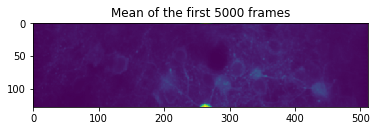

In [9]:
movie_reg = nwbfile.acquisition['Registered movie {}'.format(movie_number)].data[:5000,:,:]
movie_reg_mean= np.mean(movie_reg,0)
plt.imshow(movie_reg_mean)
plt.title('Mean of the first 5000 frames')

As a sanity check, let's use the first ROI mask to extract its trace from the raw movie, and overlay it with the ROI trace that was pre-packaged in this .nwb file.

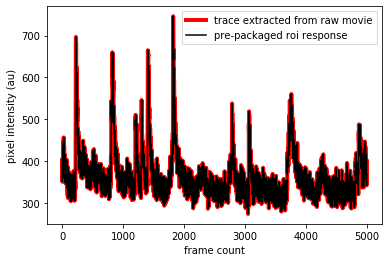

In [10]:
roi_now = ophys['ImageSegmentation']['MovieSegmentation']['image_mask'].data[0]

movie_flat  = np.reshape(movie_reg, (movie_reg.shape[0],-1))
roi_flat = roi_now.flatten()
f_extracted = np.dot(movie_flat[:,roi_flat>0], roi_flat[roi_flat>0]) # extract the trace from the movie

plt.plot(f_extracted, 'r-',linewidth = 4,label = 'trace extracted from raw movie')


f_pre_packaged = ophys['Fluorescence']['RoiResponseSeries'].data[0,:5000] # pre-packaged trace
plt.plot(f_pre_packaged, 'k-',label = 'pre-packaged roi response')
plt.ylabel('pixel intensity (au)')
plt.xlabel('frame count')
plt.legend()

# Ephys
The following lines show how to extract the raw electrophyisiolgy trace for the same movie selected above, the spike times and spike peak indices on the electrophysiology trace. The trace can either be in current clamp or in voltage clamp recording mode. 

We stimulated during some of the voltage clamp recordings, which can be seen on the stimulus trace, or on the artefacts of the response trace.

In [11]:
ephys = nwbfile.acquisition['loose seal recording for movie {}'.format(movie_number)]
ephys_trace = ephys.data[:]
if ephys.unit == 'volts':
    ephys_trace = ephys_trace*1000
    ephys_unit = 'mV'
else:
    ephys_trace = ephys_trace*1e12
    ephys_unit = 'pA'
ephys_time = np.arange(len(ephys_trace))/ephys.rate+ephys.starting_time
ap_times = nwbfile.analysis['responses']['ap_time'].data[:]
ap_times = ap_times[(ap_times>np.min(ephys_time)) &(ap_times<np.max(ephys_time))]
ap_indices = []
for ap_now in nwbfile.analysis['responses']['response'].data[:]:
    if ap_now[2].sweep_number==movie_number:
        ap_indices.append(ap_now[0])
ap_indices = np.asarray(ap_indices) 

print(ephys)

loose seal recording for movie 1 pynwb.icephys.CurrentClampSeries at 0x140348435326864
Fields:
  bias_current: 0.0
  bridge_balance: 0.0
  capacitance_compensation: 0.0
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (8294592,), type "<f8">
  description: no description
  electrode: Micropipette pynwb.icephys.IntracellularElectrode at 0x140348436189392
Fields:
  description: Micropipette (3–9 MOhm) filled with sterile saline containing 20 micromolar AlexaFluor 594
  device: Multiclamp 700B pynwb.device.Device at 0x140348435326800
Fields:
  description: with 20 kHz low-pass filter
  manufacturer: Axon Instruments


  gain: 0.02
  rate: 50000.0
  resolution: nan
  starting_time: 215.639999
  starting_time_unit: seconds
  stimulus_description: N/A
  sweep_number: 1
  unit: volts



### Note that also the epochs table can be used to pair the ephys and ophys traces:
Each epoch is one movie with the corresponding ROI traces and electrophysiological recording.

In [12]:
nwbfile.epochs[:]

,start_time,stop_time,timeseries
id,,,
0,0.000000,165.091840,"[[0, 8254591, loose seal recording for movie 0..."
1,215.639999,381.531839,"[[0, 8294592, loose seal recording for movie 1..."
2,409.044000,574.596640,"[[0, 8277632, loose seal recording for movie 2..."
3,620.575999,784.555519,"[[0, 8198975, loose seal recording for movie 3..."
4,853.267999,1016.363039,"[[0, 8154752, loose seal recording for movie 4..."
5,1044.038999,1213.039959,"[[0, 8450048, loose seal recording for movie 5..."
6,1234.873000,1398.881960,"[[0, 8200448, loose seal recording for movie 6..."


# Drifting gratings visual stimulus
The information regarding the visual stimulus is in the trial field of the .nwb file. To select the visual stimuli during the selected movie, you can either use the timing of the visual stimuli or the "movie_number" column in the trials table.

The script below also calculates the tuning curve of the recorded neuron for this movie.

#TODO movie_number solution should be added

In [13]:
angle_list = []
apnum_list = []
dff_list = []
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[:],nwbfile.trials['stop_time'].data[:],nwbfile.trials['angle'].data[:]):
    if stim_start_t_now>roi_time[0] and stim_start_t_now<roi_time[-1]:
        angle_list.append(a)
        visual_stim_ap_num = np.sum((ap_times>stim_start_t_now)&(ap_times<stim_end_t_now))
        baseline_ap_num = np.sum((ap_times<stim_start_t_now)&(ap_times>stim_start_t_now-(stim_end_t_now-stim_start_t_now)))
        apnum_list.append(visual_stim_ap_num-baseline_ap_num)
        
        stim_start_imaging = np.argmax(roi_time>stim_start_t_now)
        if np.argmax(roi_time>stim_end_t_now)==0:  
            stim_end_imaging = len(roi_time) 
        else:  
            stim_end_imaging = np.argmax(roi_time>stim_end_t_now)
        recorded_roi_f = f_corrected_of_recorded_cell[stim_start_imaging:stim_end_imaging]
        recorded_roi_f0 = np.mean(f_corrected_of_recorded_cell[np.argmax(roi_time>stim_start_t_now-.7):np.argmax(roi_time>stim_start_t_now)])
        recorded_roi_dff = (recorded_roi_f-recorded_roi_f0)/recorded_roi_f0
        dff_list.append(np.mean(recorded_roi_dff[recorded_roi_dff>=np.percentile(recorded_roi_dff,75)]))
unique_angles = np.unique(angle_list)
dff_mean_list = []
dff_std_list = []

ap_mean_list = []
ap_std_list = []
for a in unique_angles:
    apnum_mean = np.mean(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    apnum_std = np.std(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    ap_mean_list.append(apnum_mean)
    ap_std_list.append(apnum_std)
    dff_mean_list.append(np.mean(np.asarray(dff_list)[np.asarray(angle_list)==a]))
    dff_std_list.append(np.std(np.asarray(dff_list)[np.asarray(angle_list)==a]))

print(nwbfile.trials)

trials pynwb.epoch.TimeIntervals at 0x140348434971024
Fields:
  colnames: ['start_time' 'stop_time' 'angle' 'cycles_per_second' 'cycles_per_degree'
 'amplitude' 'movie_number']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    angle <class 'hdmf.common.table.VectorData'>,
    cycles_per_second <class 'hdmf.common.table.VectorData'>,
    cycles_per_degree <class 'hdmf.common.table.VectorData'>,
    amplitude <class 'hdmf.common.table.VectorData'>,
    movie_number <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>



# Plot
Figures explaining the data in this .nwb file. There is more metadata in the file than what is plotted here. Please see figure legend below.

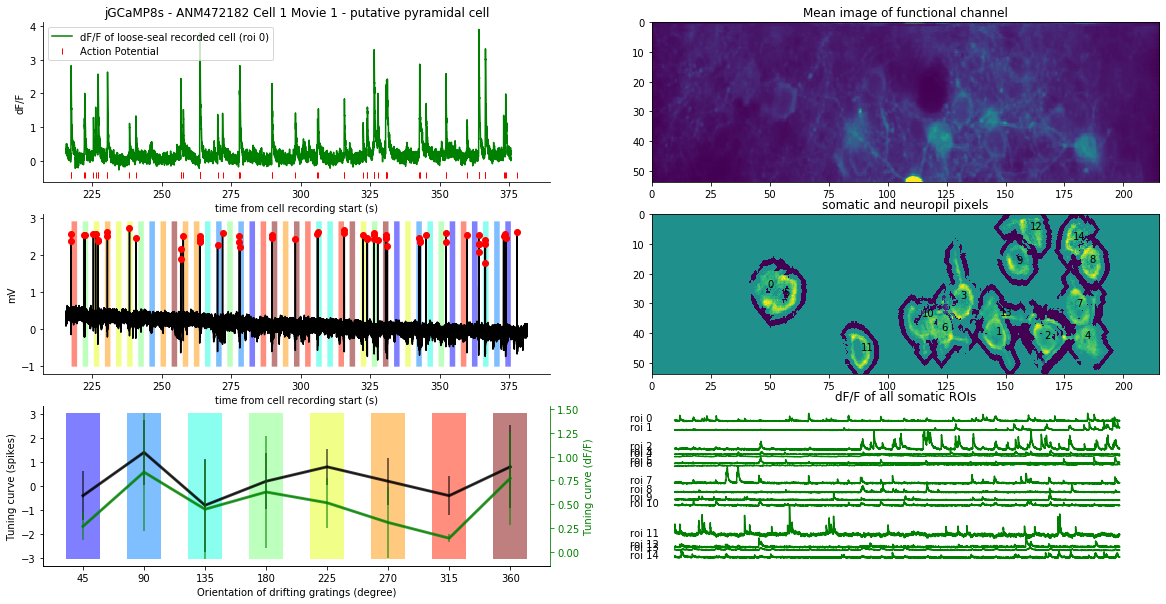

In [14]:
fig = plt.figure(figsize = [20,10])
ax_ophys_all = fig.add_subplot(3,2,6)
ax_roi_shape = fig.add_subplot(3,2,4)
ax_meanimage = fig.add_subplot(3,2,2)
ax_ophys_recorded = fig.add_subplot(3,2,1,sharex = ax_ophys_all)
ax_ephys = fig.add_subplot(3,2,3,sharex = ax_ophys_all)
ax_visual_stim = fig.add_subplot(3,2,5)
ax_visual_stim_dff = ax_visual_stim.twinx()
ax_ephys.plot(ephys_time,ephys_trace,'k-')
ax_ephys.plot(ephys_time[ap_indices],ephys_trace[ap_indices],'ro')
ax_ophys_all.axis('off')

ax_meanimage.set_title('Mean image of functional channel')
ax_ophys_all.set_title('dF/F of all somatic ROIs')
ax_roi_shape.set_title('somatic and neuropil pixels')
ax_ophys_recorded.set_title('{} - ANM{} Cell {} Movie {} - putative {}'.format(sensor,472182,cell_number,movie_number,putative_cell_type))
ax_ophys_recorded.set_ylabel('dF/F')
ax_ophys_recorded.set_xlabel('time from cell recording start (s)')
ax_ophys_recorded.spines['top'].set_visible(False)
ax_ophys_recorded.spines['right'].set_visible(False)
ax_ephys.set_ylabel('{}'.format(ephys_unit))
ax_ephys.set_xlabel('time from cell recording start (s)')
ax_ephys.spines['top'].set_visible(False)
ax_ephys.spines['right'].set_visible(False)
ax_visual_stim.set_xlabel('Orientation of drifting gratings (degree)')
ax_visual_stim.set_ylabel('Tuning curve (spikes)')
ax_visual_stim_dff.set_ylabel('Tuning curve (dF/F)')
ax_visual_stim_dff.spines['right'].set_color('green')
ax_visual_stim_dff.tick_params(axis='y', colors='green')
ax_visual_stim_dff.yaxis.label.set_color('green')
ax_visual_stim.spines['top'].set_visible(False)
ax_visual_stim.spines['right'].set_visible(False)
ax_visual_stim_dff.spines['top'].set_visible(False)

ax_meanimage.imshow(mean_image_GCaMP)
im_green = ax_meanimage.imshow(mean_image_GCaMP, extent=[0,mean_image_GCaMP.shape[1]*float(movie_pixel_size),mean_image_GCaMP.shape[0]*float(movie_pixel_size),0], aspect='auto')
clim = np.percentile(mean_image_GCaMP.flatten(),[.1,99.9])
im_green.set_clim(clim)
im_rois = ax_roi_shape.imshow(roi_image, extent=[0,roi_image.shape[1]*float(movie_pixel_size),roi_image.shape[0]*float(movie_pixel_size),0], aspect='auto')
for roi_i,center_idx in enumerate(roi_center_indices):
    ax_roi_shape.text(np.median(center_idx[0])*movie_pixel_size,np.median(center_idx[1])*movie_pixel_size,'{}'.format(roi_i))
offset = 0
for roi_i,dff in enumerate(roi_dff_list):
    offset -= np.percentile(dff,100)
    ax_ophys_all.plot(roi_time,dff+offset,'g-',alpha=1)
    ax_ophys_all.text(roi_time[0]-.1*(np.max(roi_time)-np.min(roi_time)),offset,'roi {}'.format(roi_i))
    if roi_i ==0:
        ax_ophys_recorded.plot(roi_time,dff,'g-',alpha=1,label = 'dF/F of loose-seal recorded cell (roi 0)')
        ax_ophys_recorded.plot(ap_times,np.zeros(len(ap_times))-.1*(np.max(dff)-np.min(dff)),'r|',label = 'Action Potential')
        f_corrected_of_recorded_cell = f_corrected
        ax_ophys_recorded.legend()
#%
cmap = colormap.get_cmap('jet')
ylimits_ephys = ax_ephys.get_ylim()
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[:],nwbfile.trials['stop_time'].data[:],nwbfile.trials['angle'].data[:]):
    if stim_start_t_now>roi_time[0] and stim_start_t_now<roi_time[-1]:
        ax_ephys.fill_between(ephys_time,
                                    ylimits_ephys[0],
                                    ylimits_ephys[1]   , 
                                    where= (ephys_time > stim_start_t_now) & (ephys_time < stim_end_t_now), 
                                    facecolor=cmap(a/360), #orientation_colors[int(a/45 % 4 -1)],#
                                    alpha=0.5)



ax_visual_stim.plot(unique_angles,ap_mean_list,'k-',linewidth = 3,alpha = .7)
ax_visual_stim.errorbar(unique_angles,ap_mean_list,ap_std_list,color = 'black',alpha = .7)


ax_visual_stim_dff.plot(unique_angles,dff_mean_list,'g-',linewidth = 3,alpha = .7)
ax_visual_stim_dff.errorbar(unique_angles,dff_mean_list,dff_std_list,color = 'green',alpha = .7)

y_limits_visual_stim = ax_visual_stim.get_ylim()
width = 25#np.mean(np.diff(unique_angles))*.8
for a in [45,90,135,180,225,270,315,360]:#range(0,370,10):#unique_angles:
    ax_visual_stim.bar(a,y_limits_visual_stim,width = width,color = cmap(a/360) ,alpha = .5) #cmap(a/360)  orientation_colors[int(a/45 % 4 -1)]
    
ax_visual_stim.set_xticks(unique_angles)

#io.close()

**Top left**: dF/F and action potential times (from ephys) of the loose-seal recorded neuron <br>
**Middle left**: loose-seal recording overlaid with the orientation of the drifting gratings visual stimulus. See colormap on below. Action potential peaks are highlighted with red dots. <br>
**Bottom left**: Tuning curve of the recorded cell calculated from the recording above. Black line is calculated from electrophysiology, green line is calculated from calcium imaging <br>
**Top right**: Mean image of the calcium sensor channel <br>
**Middle right**: ROI (yellow) and neuropil (blue) pixels for each cell. ROI pixels are weighted by the Suite2p pipeline. Each ROI is numbered. <br>
**Bottom rigth**: dF/F for all the ROIs on the panel above.